# Bike Sharing Project

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import probplot

In [2]:
df = pd.read_csv("train.csv", parse_dates=True, index_col = 0)
df_train = pd.read_csv("train.csv", parse_dates=True, index_col = 0)
df_test =pd.read_csv("test.csv",  parse_dates=True, index_col = 0)
df_13_14 = pd.read_csv("bike_13_14.csv", parse_dates=True,index_col = 0) # Extracted from the website and weather API



In [3]:
df_test_2 = pd.read_csv("bike_15_16_train.csv") # 2015 and 2016 data as test datat

Concatenation of 2011/12 and 2013/14 data:

In [4]:
df_train = pd.concat([df_train, df_13_14], sort=True)
df_train.index = pd.to_datetime(df_train.index)
df_train.drop(["casual","holiday", "workingday", "weather", "registered","season"], axis=1 , inplace=True)

We have outliers in counts column

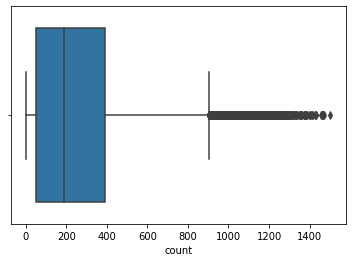

In [5]:
sns.boxplot(df_train["count"])

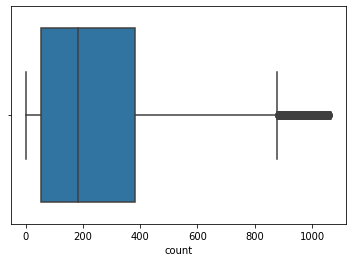

In [6]:
df_train = df_train [np.abs(df_train ["count"]-df_train ["count"].mean())<=(3 * df_train ["count"].std())] 
sns.boxplot(df_train["count"])

### Counts by year:

Text(0.5, 1.0, 'Year by total counts')

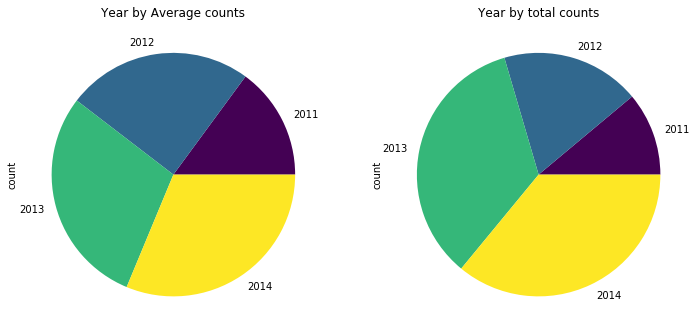

In [7]:
df_train["year"] = df_train.index.year
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
df_train.groupby(["year"])["count"].mean().plot.pie( legend = False, cmap='viridis')
plt.title("Year by Average counts")

plt.subplot(1,2,2)
df_train.groupby(["year"])["count"].sum().plot.pie( legend = False, cmap='viridis')
plt.title("Year by total counts")

### Counts by month:

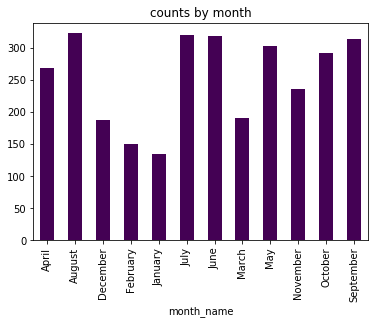

In [8]:
df_3 = df_train
df_train["month_name"] = df_train.index.month_name()
df_3["month"] = df_train.index.month



df_3= df_train.groupby(["month_name"])["count"].mean()




df_3.plot.bar( legend = False, cmap='viridis')
plt.title("counts by month")

plt.show()

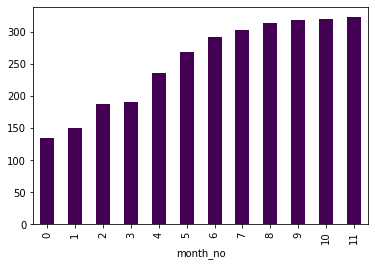

In [9]:
df_train["month"] = df_train.index.month
df_train["month_no"] = df_train.index.month
df_month=df_train.groupby("month")["count"].mean().sort_values()
# df_hour.plot.bar(color="r")
df_month =df_month.reset_index()
# print(df_month)
# print(type(df_hour))

hour = list(df_month["month"])
new_hour = list(df_month.index)

rename_dic_m = dict(zip(hour, new_hour))

df_train["month_no"].replace(rename_dic_m, inplace=True)


df_train.groupby("month_no")["count"].mean().plot.bar(cmap='viridis')



### Counts by season:

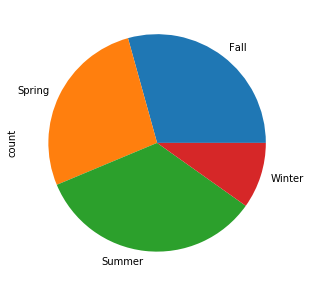

In [10]:
df_train["season"] =np.nan
df_train["season"][(df_train["month"]>= 3) & (df_train["month"]< 6)] ="Spring"
df_train["season"][(df_train["month"]>= 6) & (df_train["month"]< 9)] = "Summer"
df_train["season"][(df_train["month"]>= 9) & (df_train["month"]< 12)] = "Fall"
df_train["season"][(df_train["month"]>= 0) & (df_train["month"]< 3)] ="Winter"

plt.figure(figsize=(5,5))
df_train.groupby(["season"])["count"].sum().plot.pie()


### Days of the week:

In [11]:
df_train["days"] = df_train.index.dayofweek
df_train["week_days"] = df_train.index.day_name()

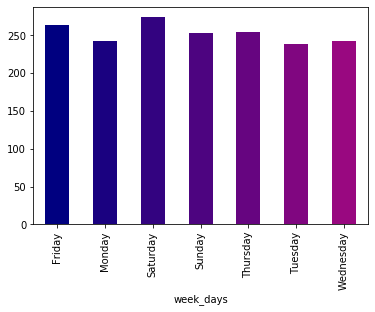

In [12]:
my_colors = [(x/10, x/200.0, 0.5) for x in range(7)]
df_train.groupby("week_days")["count"].mean().plot.bar(color =my_colors)

## Counts by hour:

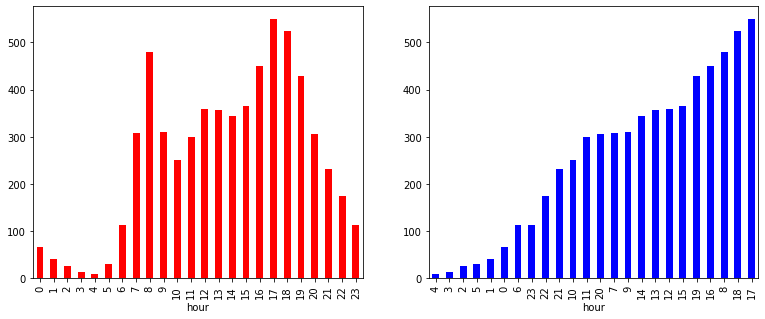

In [13]:
df_train["hour"] = df_train.index.hour
df_hour= df_train

df_hour["hour"] = df_hour.index.hour

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
df_hour.groupby("hour")["count"].mean().plot.bar(color="r")

plt.subplot(1,2,2)
df_hour=df_train.groupby("hour")["count"].mean().sort_values()
df_hour.plot.bar(color="b")


## Counts by Hour, Day and Month:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

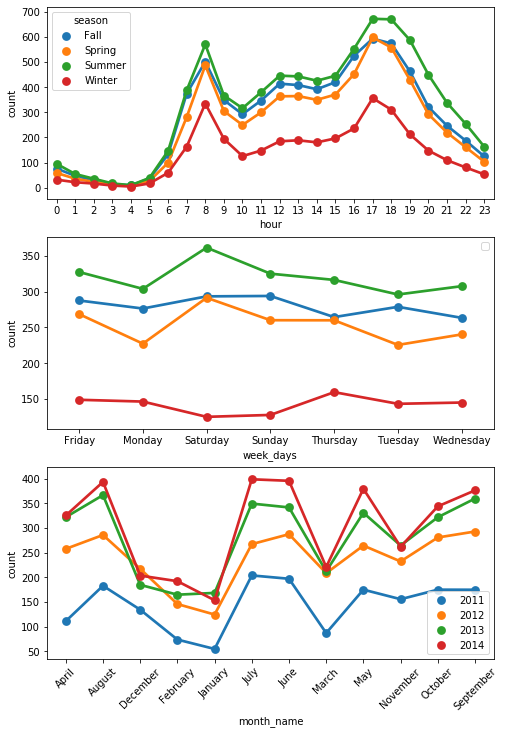

In [14]:
df_hour_season = df_train.groupby(["hour", "season"], sort=True)["count"].mean().reset_index()
df_day_season = df_train.groupby(["week_days", "season"], sort=True)["count"].mean().reset_index()
df_month_year = df_train.groupby(["month_name", "year"], sort=True)["count"].mean().reset_index()

plt.figure(figsize=(8,12))

plt.subplot(3,1,1)
sns.pointplot(x=df_hour_season["hour"], y=df_hour_season["count"],hue=df_hour_season["season"], data=df_hour_season, join=True)

plt.subplot(3,1,2)
sns.pointplot(x=df_day_season["week_days"], y=df_day_season["count"],hue=df_day_season["season"], data=df_day_season, join=True)
plt.legend("")

plt.subplot(3,1,3)
sns.pointplot(x=df_month_year["month_name"], y=df_month_year["count"],hue=df_month_year["year"], data=df_month_year, join=True)
plt.legend(loc = "lower right")
plt.xticks(rotation =45)

### Analyzing Pair Plot

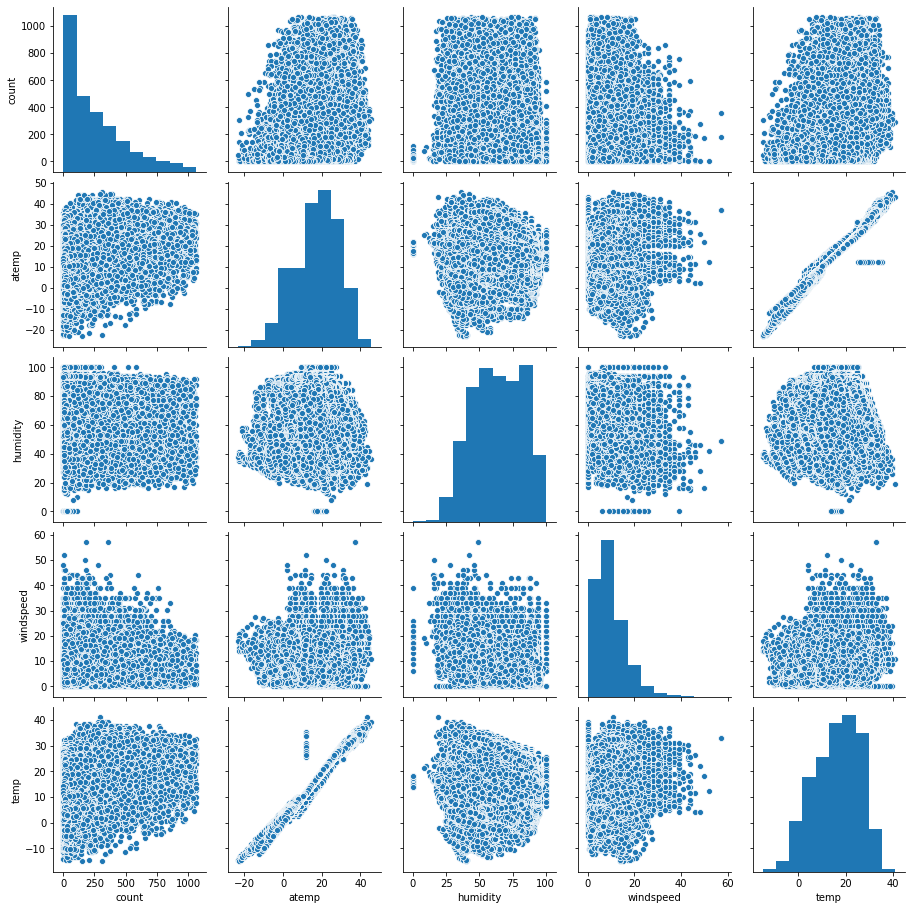

In [15]:
df_4 = df_train[["count","atemp", "humidity", "windspeed","temp"]]

sns.pairplot(df_4)
plt.show()


### Gauss-Markov Theorem function:

In [16]:
def blue_func(feature):
    plt.figure(figsize=(12,10))

    # Assumption 1: Linear relationship between X and y
    plt.subplot(2,2,1)
    plt.scatter(df_train[feature], df_train["count"], s= 8)
    plt.xlabel(feature)
    plt.ylabel("counts")
    plt.title("Linear relationship between X and y")


    # Assumption 2: Residual mean = 0
    plt.subplot(2,2,2)
    lr= LinearRegression(normalize=True)
    X= (np.array(df_train[feature]).reshape(-1,1))
    y= np.log1p(df_train["count"])
    
    lr.fit(X,y)
    ypred = lr.predict(X)

    # Assumption 3: Homoscedasticity
    residual =  ypred-y
    plt.title(f"Residual mean = {round(residual.mean(),2)}")
    residual.hist()

    plt.subplot(2,2,3)
    probplot(residual, plot=plt)

    # Assumption 5: No correlation between residuals and X
    plt.subplot(2,2,4)
    plt.scatter(df_train[feature], residual, s= 8)

    plt.xlabel(feature)
    plt.ylabel("residuals")
    plt.title("X and residuals correlation")

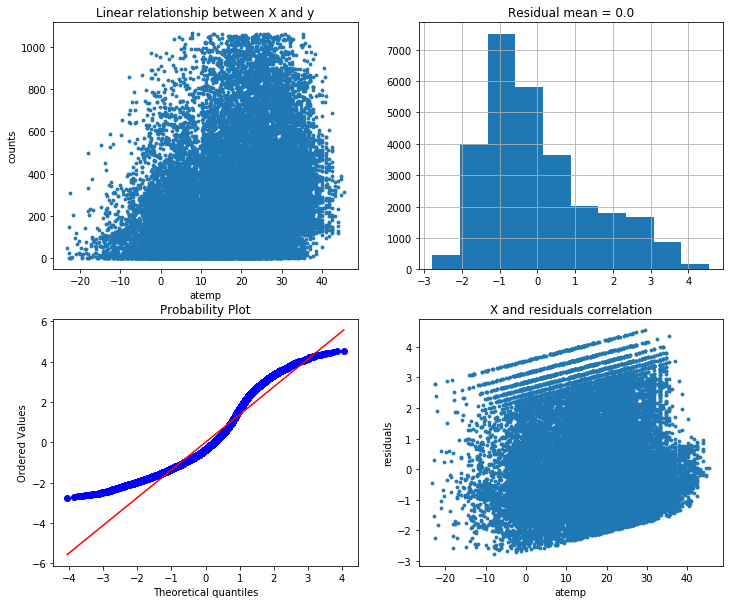

In [17]:
blue_func("atemp")

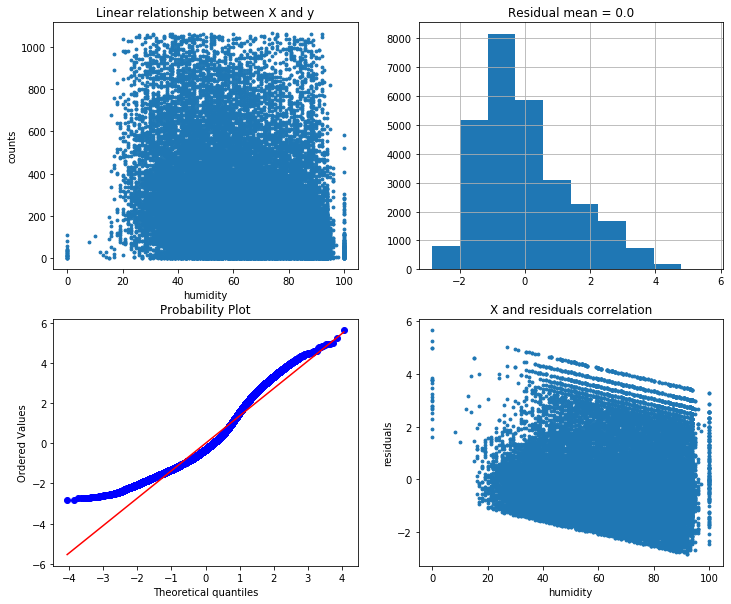

In [18]:
blue_func("humidity")

We have lots of 0 and we can bin this column

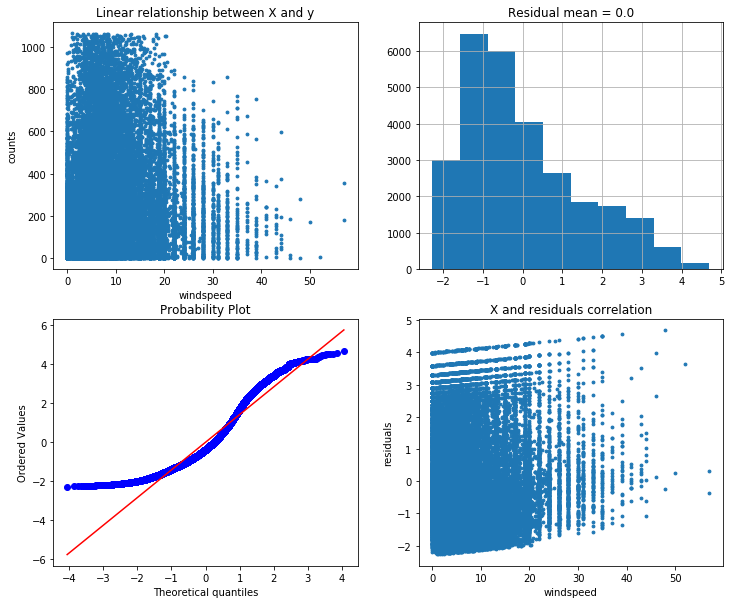

In [19]:
blue_func("windspeed")

Hour column:

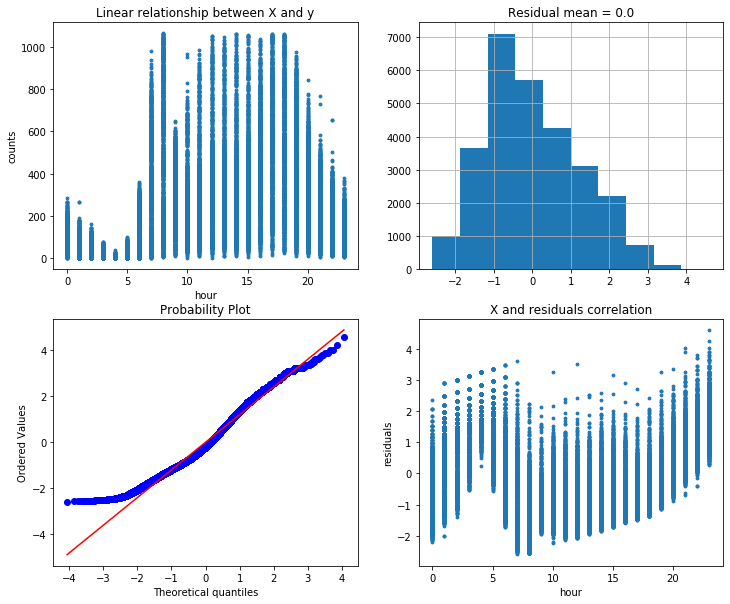

In [20]:
blue_func("hour")

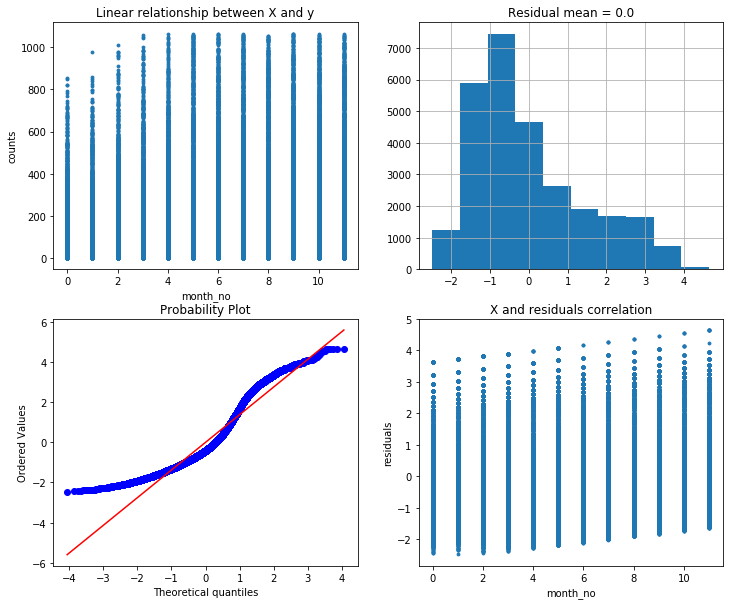

In [21]:
blue_func("month_no")

Humidity column:

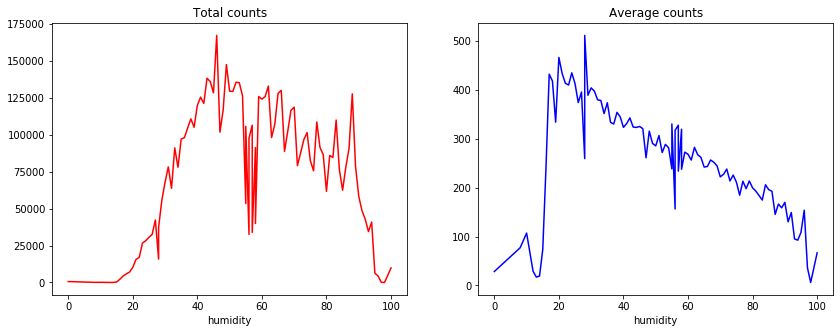

In [22]:
plt.figure(figsize= (14,5))

plt.subplot(1,2,1)
df_train.groupby("humidity")["count"].sum().plot(color="r")
plt.title("Total counts")

plt.subplot(1,2,2)
df_train.groupby("humidity")["count"].mean().plot(color="b")
plt.title("Average counts")


df_humi = df_train.groupby(["atemp","humidity"])["count"].mean()


Comparing temp and atemp columns:

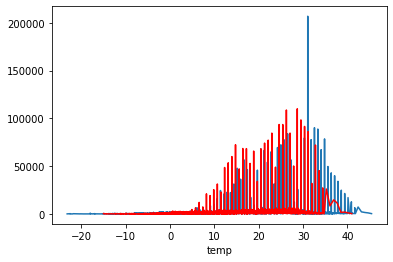

In [23]:

df_train.groupby("atemp")["count"].sum().plot()
df_train.groupby("temp")["count"].sum().plot(color="r")


#df_train["2011-03-10"] #this day has to be deleted

Scaling the temprature column like hour and month:

In [24]:
df_train["temp_no"]= df_train["temp"]
df_temp=df_train.groupby("temp")["count"].sum().sort_values()

df_temp = df_temp.reset_index()
temp = list(df_temp["temp"])
new_temp = list(df_temp.index)

rename_dic_temp = dict(zip(temp, new_temp))

df_train["temp_no"].replace(rename_dic_temp, inplace=True)

df_train[["temp","temp_no"]]



,temp,temp_no
2011-01-01 00:00:00,9.84,3892.0
2011-01-01 01:00:00,9.02,3889.0
2011-01-01 02:00:00,9.02,3889.0
2011-01-01 03:00:00,9.84,3892.0
2011-01-01 04:00:00,9.84,3892.0
...,...,...
2014-12-31 19:00:00,-0.42,1208.0
2014-12-31 20:00:00,-1.18,669.0
2014-12-31 21:00:00,-1.99,1949.0
2014-12-31 22:00:00,-2.31,579.0


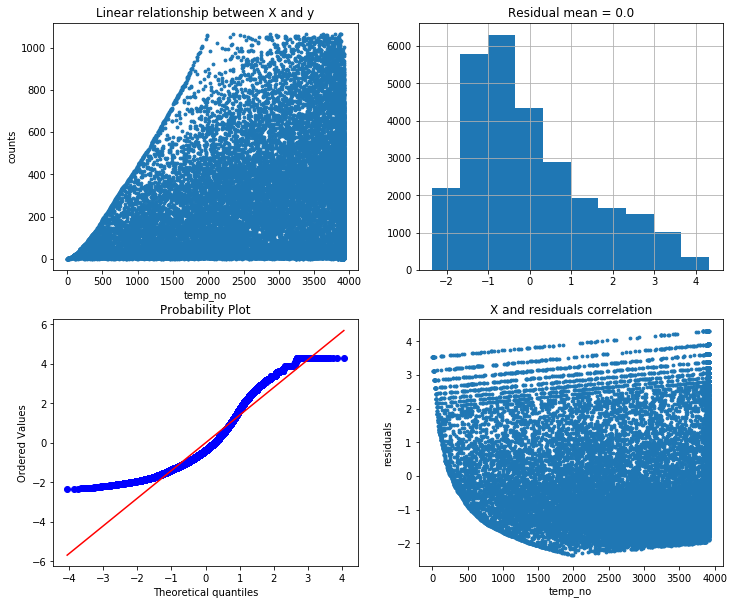

In [25]:
blue_func("temp_no")

### Binning:

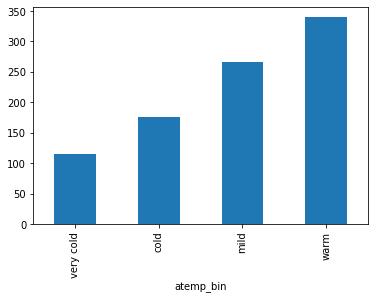

In [26]:
df_train["atemp_bin"] = pd.cut(df_train["atemp"],4, labels= ["very cold", "cold", "mild", "warm"])

df_train.groupby("atemp_bin")["count"].mean().sort_values().plot.bar()




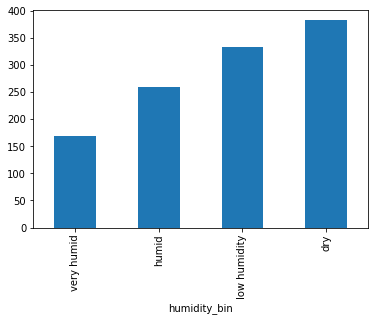

In [27]:
df_train["humidity_bin"] = pd.cut(df_train["humidity"],4, labels= ["dry", "low humidity", "humid", "very humid"])

df_train.groupby("humidity_bin")["count"].mean().sort_values().plot.bar()


Get dummies form the binning columns:

In [28]:
df_train = pd.get_dummies(data= df_train,columns =["atemp_bin","humidity_bin"], drop_first=True)


## Transforming hour column for linear models:

In [29]:
df_hour =df_hour.reset_index()
print(df_hour)
print(type(df_hour))

hour = list(df_hour["hour"])
new_hour = list(df_hour.index)

rename_dic = dict(zip(hour, new_hour))
df_train["hour_no"] = df_train.index.hour
df_train["hour_no"].replace(rename_dic, inplace=True)


    hour       count
0      4    7.693825
1      3   13.141725
2      2   26.537607
3      5   30.491525
4      1   40.498734
5      0   66.778716
6      6  111.509291
7     23  112.515612
8     22  173.232911
9     21  231.515612
10    10  250.784628
11    11  299.485618
12    20  306.111392
13     7  308.242604
14     9  309.563821
15    14  342.939779
16    13  357.470738
17    12  358.625212
18    15  364.561969
19    19  428.023629
20    16  449.699153
21     8  480.165333
22    18  524.969668
23    17  549.167173
<class 'pandas.core.frame.DataFrame'>


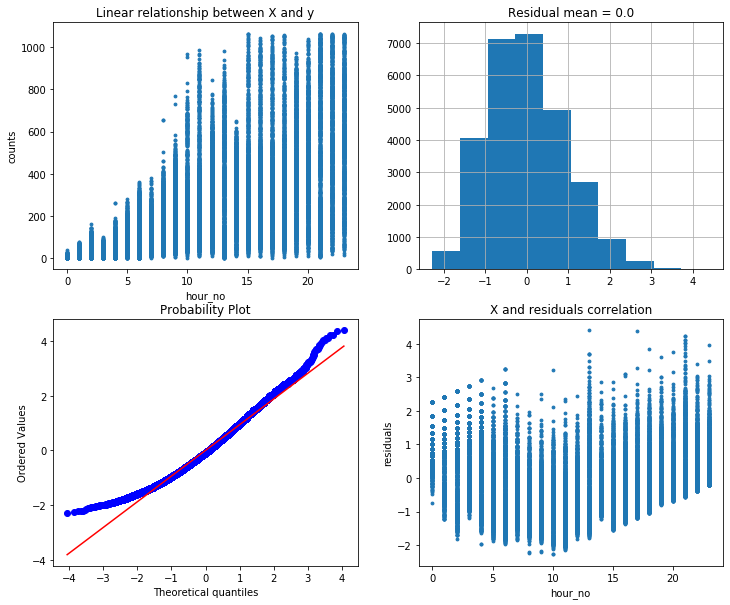

In [30]:
blue_func("hour_no")

### Filling the 0 values in humidity by Random Forrest Regressor:

In [31]:
from sklearn.ensemble import RandomForestRegressor

df_wind = df_train

wind_0 = df_wind[df_wind["windspeed"]==0]
wind_1 = df_wind[df_wind["windspeed"]!=0]
wind_feature = ["atemp", "temp", "humidity", "month"]

rf = RandomForestRegressor()
rf.fit(wind_1[wind_feature],wind_1["windspeed"] )

wind_pred = rf.predict(wind_0[wind_feature])

wind_0["windspeed"] = wind_pred


wind_com = pd.concat([wind_1,wind_0], sort=True)

wind_com.sort_index(inplace=True)
df_train["windspeed"] = wind_com["windspeed"]



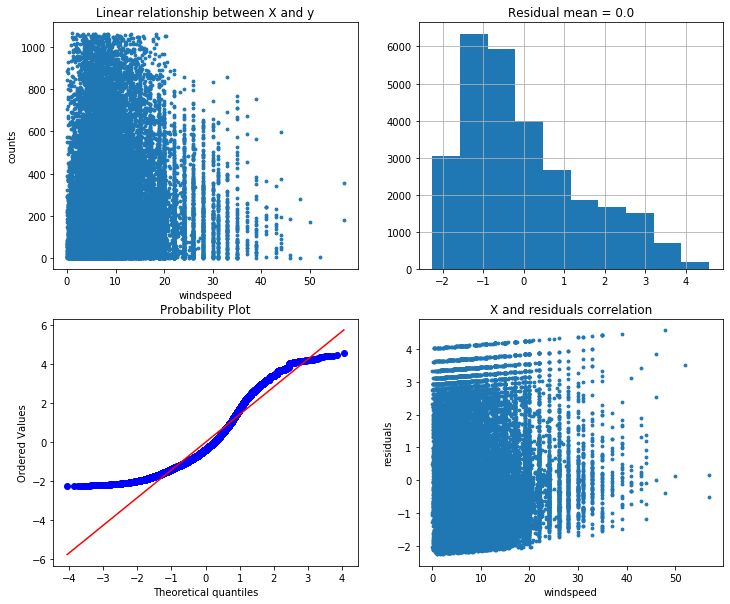

In [32]:
blue_func("windspeed") #it had a huge diffrence in the original data

In [33]:
df_train.columns

Index(['atemp', 'count', 'humidity', 'temp', 'windspeed', 'year', 'month_name',
       'month', 'month_no', 'season', 'days', 'week_days', 'hour', 'temp_no',
       'atemp_bin_cold', 'atemp_bin_mild', 'atemp_bin_warm',
       'humidity_bin_low humidity', 'humidity_bin_humid',
       'humidity_bin_very humid', 'hour_no'],
      dtype='object')

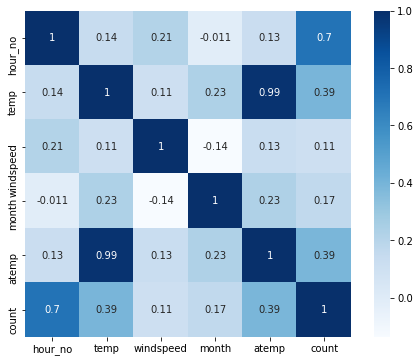

In [34]:
feature_list = ["hour_no", 'temp' ,"windspeed",'month',"atemp"]


hmap = df_train[feature_list]
hmap["count"] =df["count"]
plt.figure(figsize = (8,6))
sns.heatmap(hmap.corr(),cmap="Blues",vmax=1, square=True,annot=True,)


## Fit the models:

Pipeline: polynominal -> Ridge/Lasso

In [35]:
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error,make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score

X_train = (df_train[feature_list])
y_train = np.log1p(df_train["count"])

pipe_r = make_pipeline(PolynomialFeatures(degree=8),
    Ridge(alpha= 0.0001,normalize=True))


pipe_l = make_pipeline(PolynomialFeatures(degree=8),
    Lasso(alpha =1e-06, normalize=True))


params_r = {
    'polynomialfeatures__degree': [8], # from 3 to 15 tried  and 8 is the best
    'ridge__alpha': [0.0001]} 

params_l = {'polynomialfeatures__degree': [8],  # from 3 to 15 tried and 8 is the best
            'lasso__alpha': [1e-06]} # from 1e-08 to 100

def RMSE_func(y_true,y_pred):
     return np.sqrt(mean_squared_error(y_true,y_pred))
    

RMSE = make_scorer(RMSE_func, greater_is_better=False)








Lasso model:

In [36]:
# gs_l = GridSearchCV(pipe_l, params_l, 
#                   return_train_score=True, 
#                   scoring= RMSE, 
#                   cv=5, n_jobs=4).fit(X_train, y_train)

In [37]:
# res = pd.DataFrame(gs.cv_results_)
# c = ['param_polynomialfeatures__degree', 'param_lasso__alpha', 'mean_test_score', 'mean_train_score']
# res.sort_values('mean_test_score')[c]

In [38]:
pipe_l.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=8, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1e-06, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=True, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [39]:
ypred = pipe_l.predict(X_train)
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")

print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")

R2: 79.65521313882091 %
RMSLE: 0.6649965339844631


Ridge model:

In [43]:
# gs_r = GridSearchCV(pipe_r, params_r, 
#                   return_train_score=True, 
#                   scoring= RMSE, 
#                   cv=5, n_jobs=4).fit(X_train, y_train)

In [44]:
# res = pd.DataFrame(gs_r.cv_results_)
# c = ['param_polynomialfeatures__degree', 'param_ridge__alpha', 'mean_test_score', 'mean_train_score']
# res.sort_values('mean_test_score')[c]

In [45]:
pipe_r.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=8, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=0.0001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=True, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [46]:
ypred = pipe_r.predict(X_train)
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")

print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")

R2: 80.21320717407534 %
RMSLE: 0.6558137422126018


Stochastic Gradient Descent Model:

In [47]:
from sklearn.linear_model import SGDRegressor

pipe_g = make_pipeline(PolynomialFeatures(degree=8),
                       MinMaxScaler(),
                       SGDRegressor(alpha = 0.0001, penalty="l2"))

params_g = {
    'polynomialfeatures__degree': [6], # 2 to 10 tried
    'sgdregressor__alpha': [0.00001],# from 1e-08 to 1
    } 

def RMSE_func(y_true,y_pred):
     return np.sqrt(mean_squared_error(y_true,y_pred))
    

RMSE = make_scorer(RMSE_func, greater_is_better=True)

gs_g = GridSearchCV(pipe_g, params_g, 
                  return_train_score=True, 
                  scoring= RMSE, 
                  cv=5, n_jobs=4).fit(X_train, y_train)






In [48]:
ypred = gs_g.predict(X_train)
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")

print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")


R2: 75.63550572030967 %
RMSLE: 0.7277320636646012


Random Forest Model

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000,max_depth=16) # Optimized depth = 10 ,12 , 14 ,16 and estimator = 10, 100, 1000
feature_rf = ["hour_no", 'temp' ,"windspeed",'month',"atemp","year","days",
              'humidity_bin_low humidity',
              'humidity_bin_humid',
              'humidity_bin_very humid',]
X_train = (df_train[feature_rf])

rf.fit(X_train,y_train)
ypred = rf.predict(X_train)


In [50]:
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")

R2: 98.51415873232123 %
RMSLE: 0.1797128028676943


Gradient Boosting Model

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(loss ='huber', n_estimators=300, max_depth=5,)

gb.fit(X_train,y_train)
ypred = gb.predict(X_train)

In [52]:
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")

R2: 94.63422109133512 %
RMSLE: 0.3415145384556138


Extreme Gradient Boosting Model:

In [97]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(n_estimators= 300, max_depth=7, learning_rate= 0.18 )

# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(2, 6), # default 3
#     "n_estimators": randint(100, 300), # default 100
#     "subsample": uniform(0.6, 0.4)
# }

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.18, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [99]:
ypred = search.predict(X_train)
r2 = r2_score(y_train,ypred)
print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_train,ypred))}")

R2: 95.20482337194758 %
RMSLE: 0.32284577995816394


## Testing the test data from 2015/2016

In [53]:
df_test_2["Unnamed: 0"] = df_test_2["Unnamed: 0"].str[:-6]
df_test_2["Unnamed: 0"] = pd.to_datetime(df_test_2["Unnamed: 0"])
df_test_2.set_index("Unnamed: 0", inplace=True)
df_test_2.rename(columns={"Counts":"count", "Hour":"hour", "weekday":"days", "atemperatue":"atemp", \
                           "temperature":"temp", "windSpeed":"windspeed", "Month":"month"}, inplace=True)

In [54]:
def transform_func(df_train):
    
    df_train["days"] = df_train.index.dayofweek
    df_train["year"] = df_train.index.year
    
    df_train["atemp_bin"] = pd.cut(df_train["atemp"],4, labels= ["very cold", "cold", "mild", "warm"])
    df_train["humidity_bin"] = pd.cut(df_train["humidity"],4, labels= ["dry", "low humidity", "humid", "very humid"])
    df_train = pd.get_dummies(data= df_train,columns =["atemp_bin","humidity_bin"], drop_first=True)
    
    df_train["hour_no"] = df_train.index.hour
    df_train["hour_no"].replace(rename_dic, inplace=True)
    
    df_train["temp_no"] = df_train["temp"]
    df_train["temp_no"].replace(rename_dic_temp, inplace=True)
    
    df_train["month_no"] = df_train["month"]
    df_train["month_no"].replace(rename_dic_m, inplace=True)
    
    df_wind = df_train

    wind_0 = df_wind[df_wind["windspeed"]==0]
    wind_1 = df_wind[df_wind["windspeed"]!=0]
    wind_feature = ["atemp", "temp", "humidity", "month"]

    rf = RandomForestRegressor()
    rf.fit(wind_1[wind_feature],wind_1["windspeed"] )

    wind_pred = rf.predict(wind_0[wind_feature])

    wind_0["windspeed"] = wind_pred


    wind_com = pd.concat([wind_1,wind_0], sort=True)

    wind_com.sort_index(inplace=True)
    df_train["windspeed"] = wind_com["windspeed"]

    
    return df_train

In [55]:
df_test_3 = transform_func(df_test_2)

Set the X_test and y_test

In [56]:
y_test = np.log1p(df_test_3["count"])
X_test = df_test_3[feature_list]

### Rigde Model:

In [57]:
ypred = pipe_r.predict(X_test)
r2 = r2_score(y_test,ypred)



print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 80.57110448766609 %
RMSLE: 0.69374571674558


### Lasso Model:

In [58]:
ypred = pipe_l.predict(X_test)
r2 = r2_score(y_test,ypred)

print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 80.22561670449417 %
RMSLE: 0.6998866867503493


###  Stochastic Gradient Descent:

In [59]:
ypred = gs_g.predict(X_test)
r2 = r2_score(y_test,ypred)

print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 76.37874722476417 %
RMSLE: 0.7649406173044168


### Random Forrest:

In [60]:
X_test = df_test_3[feature_rf]
ypred = rf.predict(X_test)
r2 = r2_score(y_test,ypred)

print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 91.50474277407523 %
RMSLE: 0.45873779747005217


### Gradient Boosting:

In [61]:
X_test = df_test_3[feature_rf]
ypred = gb.predict(X_test)
r2 = r2_score(y_test,ypred)

print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 92.39033144953505 %
RMSLE: 0.43416931751682075


### XGBoost:

In [96]:
X_test = df_test_3[feature_rf]
ypred = search.predict(X_test)
r2 = r2_score(y_test,ypred)

print(f"R2: {r2*100} %")
print(f"RMSLE: {np.sqrt(mean_squared_error(y_test,ypred))}")

R2: 91.8945513273611 %
RMSLE: 0.4480895218019837


## Summary:

Linear regression model with ridge regularization showed the best score and better big-o notation among linear models but Gradient Boosting Model demonstrated the best performance. 

|            	|  **Ridge**	  	|  Lasso  	|   SDG   	| Random Forrest 	| Gradient Boosting | XGBoost
|:----------:	|:-------:	|:-------:	|:-------:	|:--------------:	|:--------------:           |:--------------: 
| R2-train   	| 80 % 	    | 80 %      | 76 %   	|     98 %      	|    95%                    | 95%
| R2-15/16   	| 81 %   	| 80 %      |  76%  	|     91 %      	|92 %                       | 92%
| RMSLE-train 	|   0.65  	|   0.67  	|   0.72  	|     0.018      	|0.34                       | 0.32
| RMSLE-15/16 	|   0.69  	|   0.69  	|   0.77  	|     0.46      	|0.43                       | 0.44


## Predicting the provided test data by Kaggle: 
The purpose of this project was understanding  concepts of linear regression so I submit the best linear model to Kaggle and not the ensemble model with the better performance

In [ ]:
df_test["month"] = df_test.index.month

In [ ]:
df_test = transform_func(df_test)

In [ ]:
ypred = np.expm1(pipe_r.predict(df_test[feature_list]))

In [ ]:
sub =pd.read_csv("sampleSubmission.csv", parse_dates=True, index_col = 0)

In [ ]:
sub["count"]= ypred

In [ ]:
sub

In [ ]:
sub.to_csv("Submission.csv")

# Kaggle RMSLE score: $ 0.72 $ 